<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2022/11 $-$ CC BY-SA 4.0 $-$ </span>
<img src="img/cc_icon_white_x2.png" width="20" style="vertical-align: middle;">
<img src="img/attribution_icon_white_x2.png" width="20" style="vertical-align: middle;">
<img src="img/sa_white_x2.png" width="20" style="vertical-align: middle;">

# Machine learning avec les modules Python tensorflow2/keras :

# Entraînement d'un réseau de neurones dense à classifier des données issues d'un banc de perçage

version 3.3 du 17 novembre 2022

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    Ce notebook doit être chargé dans un processus <b>jupyter notebook</b> lancé dans l'EVP <b><span style="color: rgb(80, 151, 102);">minfo_ml</span></b> créé en suivant la procédure du document <b>Consignes.pdf</b>.

## Import des modules Python requis :

In [1]:
import os, sys

# clean tensorflow warnings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# the seed to make random genetors repetables:
SEED = 1234 

import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")

Python    : 3.8.13
tensorflow: 2.8.0 incluant keras 2.8.0
numpy     : 1.21.2


### Définition de la fonction `read_csv` qui sera utilisée pour la lecture des fichiers CSV :

In [2]:
def read_csv(file: str, last_param_rank:int, verbose=False) -> (np.ndarray, np.ndarray, list, list):
    '''
    Lire les fichiers CSV (Comma Separated Values) en 'corrigeant les petits défauts'.
    Paramètres: 
      file:str: nom du fichier à lire
      last_param_rank:int: le rang de la dernière colonne paramètre (commençant à 0)
      verbole:bool: mode verbeux ou non-verbeux
    Renvoie:
      data:ndarray: le tableau ndarray des valeurs lues
      label:ndarray: le tableau ndarray des labels
      param:list: la liste des paramètres
      header:list: la liste des entêtes des colonnes
    '''
    param, data, label, header = [], [], [], []
    with open(file, encoding='utf8') as f:
        for i, line in enumerate(f):
            if i == 0: 
                header=line.strip().split(';')
                continue
            if verbose: print(i,line)
            line = line.strip().replace(',','.').split(';')
            list_param = line[:last_param_rank+1]    # from 0 to 'last_param_rank' excluded: the parameters
            list_data  = line[last_param_rank+1:-3]  # from rank 'last_param_rank' to the end: the data
            list_label = line[-1]                    # last column: the labels
            param.append(list_param)
            data.append(list_data)
            label.append(list_label)
    data = np.array(data).astype(float)
    label = np.array(label).astype(int)
    return data, label, param, header

# 1 - Lire le fichier CSV et préparer les données labellisées

## 1.1 $-$ Lire le fichier CSV :

Ouvrir le fichier CSV `Dataset.csv` avec un tableur ; le fichier est organisé en colonnes :
- la colonne `A` (*rank: 0*) donne le numéro de l'essai de perçage,
- suivent plusieurs colonnes donnant, dans l'ordre des rangs croisants :
    - les **paramètres** de perçage, commençant avec la colonne `B` (*rank: 1*) de label `Longueur percee eprouvetteAlCFRP(mm)`, jusqu'à la colonne `O` (*rank: 14*) de label `Niveau huile`,
    - suivent les **indicateurs caractéristiques** (les *features*), commençant avec la colonne de label `KcFz`: ces indicateurs sont calculée avec les données temporelles acquises sur le banc de perçage avec les différents capteurs (capteur de force, accéléromètre, capteur de courant...).
    
Le détails des traitements permettant d'obtenir certains des indicateurs avec les données temporelles brutes fera l'objet de séances de travail dédiées.

À l'aide de la fonction `read_csv` définie ci-dessus, lire le fichier `Dataset.csv` situé dans le répertoire courant:
- en observant le fichier `Dataset.csv` ouvert dans un tableur, trouver la valeur du rang de la dernière colonne des paramètres,
- nommer `data`, `label`, `param` et `header` les objets renvoyés par la fonction...

In [3]:
data, label, param, header = read_csv('Dataset.csv', 14)

Faire afficher l'attribut `shape` des tableaux `data` et `label`:

In [4]:
data.shape, label.shape 

((356, 50), (356,))

Est-ce que ces valeurs paraissent en cohérence avec le contenu du ficher CSV ?<br>
$\leadsto$ **Il est important de pouvoir expliquer les valeurs des dimensions des tableaux...**

Vérifier les données de la première ligne du tableau `data` par comparaison visuelle avec le tableur :

In [5]:
# un coup d'oeil sur la première ligne ds données: 50 nombres flottants
data[0]  

array([ 4.07111857e+02,  4.67130779e+02, -1.68192509e+01,  2.59126697e+02,
        1.41883454e+02, -1.44707830e+00, -2.38782680e-01,  2.01309146e+04,
        1.27532583e+00,  5.24100367e+00, -4.25671060e+00,  8.11744892e-01,
        1.92336596e+00, -6.80682771e-01, -3.58838557e-01,  3.69933662e+00,
        1.13944183e+01,  4.83412238e+00,  2.92271392e+00,  5.08095204e-01,
        3.40000000e-01,  2.93000000e-01,  3.23402597e-01,  1.67168838e-02,
       -5.48846864e-01, -9.12838318e-01,  2.79454204e-04,  3.56627661e+01,
        2.32420000e+01,  2.18260000e+01,  2.26993506e+01,  4.28199252e-01,
       -5.44160812e-01, -7.39967001e-01,  1.83354599e-01,  1.07218644e+01,
        4.90193646e+00,  1.96512667e+02,  7.90036820e-01,  3.66294500e-01,
        1.15993290e+00,  3.71161500e-02,  1.43772460e-01,  1.25540392e+00,
        6.61860700e-02,  2.65101880e-01,  5.50328425e+00,  2.65337700e-02,
        4.00878300e-02,  2.41660816e+00])

Faire afficher le contenu du tableau `label` :

In [6]:
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Le tableau `label` montre qu'on a deux matériaux dans ce dataset :
- le matériau `0` est de l'aluminium Al7175,
- le matériau `1` est un composite CFRP (*Carbon-fiber-reinforced polymers*).<br>

## 1.1 $-$ Normaliser les données

Vous devez ici modifier chacune des lignes du tableau `data` pour les normaliser : les valeurs de chaque ligne après normalisation doivent être comprises dans l'intervalle [0; 1]... 

Vous devriez arriver à obtenir ce résultat sans écrire de boucle sur les lignes du tableau, en utilisant la vectorisation possible avec les tableaux `ndarray` du module *numpy*.

In [7]:
data.shape

(356, 50)

In [10]:
# la méthode `ndarray.ptp` renvoie la valeur *peak to peak* selon les diffétents xes d'un tableau:
data.ptp(axis=0)

array([6.65773857e+02, 7.76926771e+02, 9.01715406e+02, 3.16359987e+02,
       4.54801056e+02, 1.58164593e+00, 1.71039274e+00, 2.44883928e+05,
       1.12060826e+01, 2.39241562e+01, 3.15157255e+01, 5.70613725e+00,
       1.42556248e+01, 2.25965991e+00, 2.18046092e+00, 2.40515840e+02,
       1.73404654e+01, 1.53571740e+01, 7.65412368e+00, 1.27643536e+00,
       6.67000000e-01, 6.33000000e-01, 6.40356190e-01, 4.59459697e-02,
       1.05731625e+01, 4.38592951e+00, 2.58594148e-03, 8.85911598e+01,
       5.10740000e+01, 3.25690000e+01, 4.47553500e+01, 7.14764254e+00,
       2.88936058e+01, 7.85243202e+00, 5.20549778e+01, 9.54793155e+00,
       1.28384677e+02, 6.05711056e+02, 2.74887212e+00, 3.45725083e+00,
       1.70195724e+01, 1.48686958e+00, 2.22512623e+00, 9.24896088e+00,
       2.85502199e-01, 2.94460771e+00, 2.01135163e+01, 1.97121590e-01,
       5.56762630e-01, 6.15654828e+00])

In [11]:
# On peut normaliser les lignes du tableau en retranchant à chaque ligne sa valeur minimale 
# et en la divisant par sa valeur *peak to peak*:

data = (data - data.min(axis=0))/data.ptp(axis=0)

#### Vérification

Les valeurs de chacune des ligne du tableau `data` doivent être comprises entre 0 et 1:

In [12]:
print(f"valeurs min des lignes du tableau 'data' normalisé : \n{data.min(axis=0)}\n" 
      f"valeurs max des lignes du tableau 'data' normalisé : \n{data.max(axis=0)}")

valeurs min des lignes du tableau 'data' normalisé : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
valeurs max des lignes du tableau 'data' normalisé : 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


## 1.2 $-$ Découper les données en un jeu d'entraînement et un jeu de test

Avec l'aide de la page [sklearn.model_selection.train_test_split.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) utiliser la fonction `train_test_split` pour découper le tableau `data` en deux jeux de données labellisées :
- `data_train` et `label_train` $\leadsto$ données et labels d'entraînement,
- `data_val` et `label_val`  $\leadsto$  donnnées et labels de validation.<br>
On pourra par exemple regrouper 20% des données et labels pour le jeu de validation.

Il est important de passer à `train_test_split` les arguments :
- `stratify=label`, afin de répartir équitablement toutes les classes sur les deux jeux de données,
- `shuffle=True`, pour mélanger les données,
- `random_state=SEED`, pour obtenir un mélange aléatoire des données qui soit reproductible...


In [11]:
from sklearn.model_selection import train_test_split

data_train, data_val, label_train, label_val = train_test_split(data, label, 
                                                                stratify=label, 
                                                                test_size=0.2,        # 20 % test, 80% train 
                                                                random_state=SEED,    # fixer la graine des génés aléatoires
                                                                shuffle=True)         # mélanger aléatoirement les données

Vérification des dimensions des tableaux:

In [12]:
data_train.shape, data_val.shape

((284, 50), (72, 50))

In [13]:
label_train.shape, label_val.shape

((284,), (72,))

$\leadsto$ **Il est important de savoir expliquer les valeurs des dimensions des tableaux...**

## 1.4 $-$ Créer les labels au format 'one hot'

Définir `y_train` et `y_val`, les tableaux des labels d'entraînement et de validation au format *one hot* : 

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(label_train)
y_val   = to_categorical(label_val)

Vérifier visuellement les 5 premières valeurs des tableaux `label_train` et `y_train` puis `label_val` et `y_val`:

In [15]:
label_train[:5], y_train[:5]

(array([1, 0, 0, 1, 1]),
 array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]], dtype=float32))

In [16]:
label_val[:5], y_val[:5]

(array([1, 0, 1, 0, 0]),
 array([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]], dtype=float32))

## 1.5 $-$ Définir les paramètres utiles

En utilisant les attributs des tableaux *ad-hoc*, définir les paramètres suivants :

In [17]:
nb_train_set = data_train.shape[0]    # nombre de jeux d'entraînement
nb_val_set   = data_val.shape[0]      # nombre de jeux de validation
set_size     = data_train.shape[1]    # nombre de réels (float) dans un jeu
nb_classe    = len(set(label))        # nombre de classes de matériaux 

Vérification :

In [18]:
print(f"{nb_train_set} jeux d'entraînement  et {nb_val_set} jeux de validation, comprenant {set_size} scalaires dans chaque jeu")
print(f"{nb_classe} classes de matériaux")

284 jeux d'entraînement  et 72 jeux de validation, comprenant 50 scalaires dans chaque jeu
2 classes de matériaux


# 2 $-$ Construire et entraîner le réseau de neurones dense

## 2.1 $-$ Construire le du réseau dense

En vous appuyant sur les acquis d'apprentissage de l'auto-formation, contruire le RND `model` conforme aux spécifications suivantes :
- une couche d'entrée compatible avec les dimensions du jeu de connées construit plus haut, nommée `Input`,
- une couche cachée de 100 neurones, fonction d'activation `relu`, nommée `C1`,
- une couche de sortie permettant de classifier deux matières percées, nommée `Out`,<br>

Compiler le réseau avec les paramètres *ad-hoc* et faire afficher sa structure avec la méthode `summary`.

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# set the seed for repetable tenssorflow random sequences:
tf.random.set_seed(SEED)

model = Sequential()
model.add(Input(shape=(set_size,), name='Input'))
model.add(Dense(100, activation='relu', name='C1'))
model.add(Dense(nb_classe, activation='softmax', name='Out'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Dense)                  (None, 100)               5100      
                                                                 
 Out (Dense)                 (None, 2)                 202       
                                                                 
Total params: 5,302
Trainable params: 5,302
Non-trainable params: 0
_________________________________________________________________


Affichage graphique de la structure du réseau :

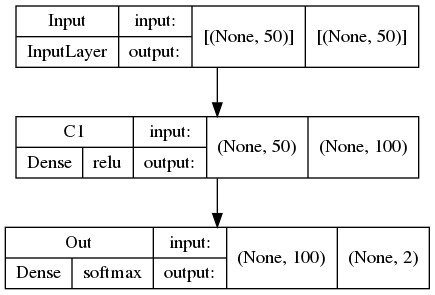

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

## 2.2 $-$ Sauvegarder les poids initiaux du réseau de neurones

- Enregistrer les poids du réseau de neurone initial dans le dossier `weights` avec le préfixe `dense_init`.
- Afficher la liste des fichiers du dossier `weights` qui commencent par `dense_init`.

In [21]:
# check that the directory exists and create it if required:
if not os.path.isdir("weights"): os.mkdir("weights")

# save the network weights:
key = 'dense_init'
model.save_weights(os.path.join('weights', key))

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/dense_init.data-00000-of-00001
weights/dense_init.index


## 2.3 $-$ Entraîner le réseau de neurones

- Recharger les poids initiaux du réseau.
- Fixer la graine des génératoires aléatoire de **tensorflow**.
- Entraîner le réseau, avec mesure des performance à chaque époque, en essayant de trouver par essais successifs des valeurs des arguments `epoch` et `batch_size` qui donnent des courbes `val_accuracy` et `val_loss` satisfaisantes.
- Afficher les courbes de précisoion et de perte...

Il est intéressant de voir l'influence de la valeur du méta-paramètre `batch_size` sur l'état du réseau  entraîné : on va explorer différentes valeurs, allant de 356 (nombre total de jeux de données), puis 128, 64, 32, 16;  et 8.

Epoch 1/12
1/1 [==============================] - 1s 503ms/step - loss: 0.6548 - accuracy: 0.6866 - val_loss: 0.6430 - val_accuracy: 0.6389
Epoch 2/12
1/1 [==============================] - 0s 24ms/step - loss: 0.6322 - accuracy: 0.7254 - val_loss: 0.6215 - val_accuracy: 0.6806
Epoch 3/12
1/1 [==============================] - 0s 24ms/step - loss: 0.6106 - accuracy: 0.7359 - val_loss: 0.6005 - val_accuracy: 0.7083
Epoch 4/12
1/1 [==============================] - 0s 31ms/step - loss: 0.5896 - accuracy: 0.8134 - val_loss: 0.5798 - val_accuracy: 0.8056
Epoch 5/12
1/1 [==============================] - 0s 30ms/step - loss: 0.5690 - accuracy: 0.8521 - val_loss: 0.5594 - val_accuracy: 0.8611
Epoch 6/12
1/1 [==============================] - 0s 24ms/step - loss: 0.5488 - accuracy: 0.8803 - val_loss: 0.5392 - val_accuracy: 0.9028
Epoch 7/12
1/1 [==============================] - 0s 24ms/step - loss: 0.5288 - accuracy: 0.9331 - val_loss: 0.5192 - val_accuracy: 0.9444
Epoch 8/12
1/1 [==========

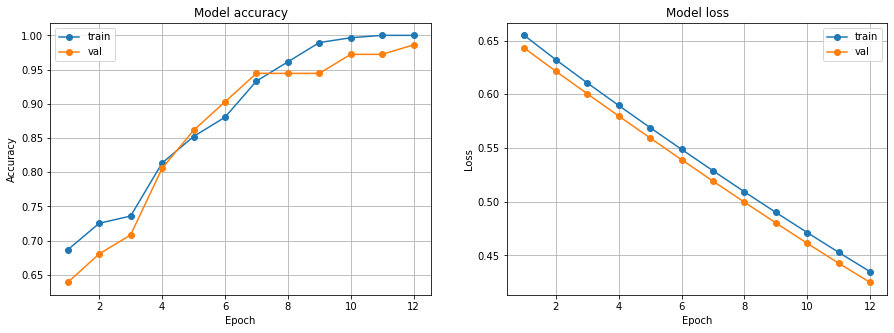

In [22]:
from time import time
t0 = time()

# reload the initial state of the NN to get repetable results:
key = 'dense_init'
model.load_weights(os.path.join('weights', key))

# set the seed for repetable tenssorflow random sequences:
tf.random.set_seed(SEED)


###
### Par curiosité, on peut essayer de prendre un bact_size ègal aux nombre d'eesais de perçage :
###

# train the network
hist = model.fit(data_train, y_train,
                 validation_data=(data_val, y_val), 
                 epochs=12, 
                 batch_size=356)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Epoch 1/12
3/3 [==============================] - 0s 37ms/step - loss: 0.6415 - accuracy: 0.7254 - val_loss: 0.6032 - val_accuracy: 0.8056
Epoch 2/12
3/3 [==============================] - 0s 11ms/step - loss: 0.5789 - accuracy: 0.8697 - val_loss: 0.5439 - val_accuracy: 0.8889
Epoch 3/12
3/3 [==============================] - 0s 12ms/step - loss: 0.5209 - accuracy: 0.9225 - val_loss: 0.4893 - val_accuracy: 0.9444
Epoch 4/12
3/3 [==============================] - 0s 11ms/step - loss: 0.4669 - accuracy: 0.9683 - val_loss: 0.4353 - val_accuracy: 0.9583
Epoch 5/12
3/3 [==============================] - 0s 12ms/step - loss: 0.4158 - accuracy: 1.0000 - val_loss: 0.3848 - val_accuracy: 0.9861
Epoch 6/12
3/3 [==============================] - 0s 12ms/step - loss: 0.3684 - accuracy: 1.0000 - val_loss: 0.3414 - val_accuracy: 1.0000
Epoch 7/12
3/3 [==============================] - 0s 11ms/step - loss: 0.3266 - accuracy: 1.0000 - val_loss: 0.3024 - val_accuracy: 1.0000
Epoch 8/12
3/3 [===========

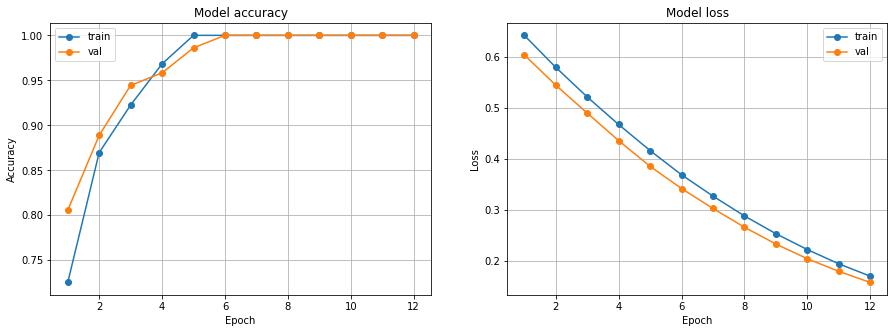

In [23]:
from time import time
t0 = time()

# reload the initial state of the NN to get repetable results:
key = 'dense_init'
model.load_weights(os.path.join('weights', key))

# set the seed for repetable tenssorflow random sequences:
tf.random.set_seed(SEED)

# train the network
hist = model.fit(data_train, y_train,
                 validation_data=(data_val, y_val), 
                 epochs=12, 
                 batch_size=128)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Epoch 1/12
5/5 [==============================] - 0s 19ms/step - loss: 0.6317 - accuracy: 0.7570 - val_loss: 0.5916 - val_accuracy: 0.8056
Epoch 2/12
5/5 [==============================] - 0s 7ms/step - loss: 0.5518 - accuracy: 0.8944 - val_loss: 0.5058 - val_accuracy: 0.9444
Epoch 3/12
5/5 [==============================] - 0s 7ms/step - loss: 0.4669 - accuracy: 0.9859 - val_loss: 0.4195 - val_accuracy: 0.9583
Epoch 4/12
5/5 [==============================] - 0s 6ms/step - loss: 0.3839 - accuracy: 1.0000 - val_loss: 0.3389 - val_accuracy: 1.0000
Epoch 5/12
5/5 [==============================] - 0s 6ms/step - loss: 0.3125 - accuracy: 1.0000 - val_loss: 0.2730 - val_accuracy: 1.0000
Epoch 6/12
5/5 [==============================] - 0s 8ms/step - loss: 0.2497 - accuracy: 1.0000 - val_loss: 0.2216 - val_accuracy: 1.0000
Epoch 7/12
5/5 [==============================] - 0s 6ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 1.0000
Epoch 8/12
5/5 [=================

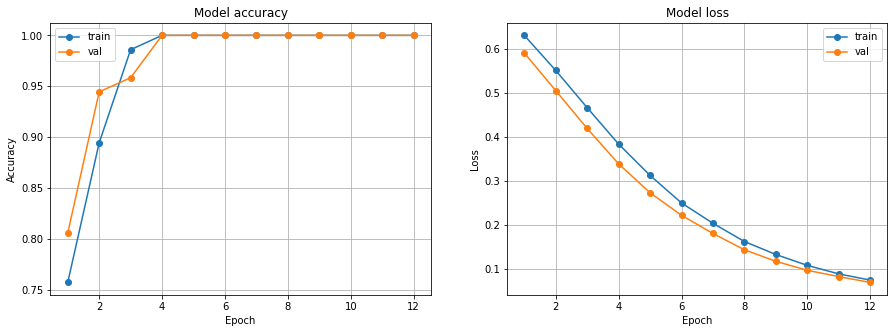

In [24]:
from time import time
t0 = time()

# reload the initial state of the NN to get repetable results:
key = 'dense_init'
model.load_weights(os.path.join('weights', key))

# set the seed for repetable tenssorflow random sequences:
tf.random.set_seed(SEED)

# train the network
hist = model.fit(data_train, y_train,
                 validation_data=(data_val, y_val), 
                 epochs=12, 
                 batch_size=64)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Epoch 1/12
9/9 [==============================] - 0s 11ms/step - loss: 0.6111 - accuracy: 0.8099 - val_loss: 0.5444 - val_accuracy: 0.9028
Epoch 2/12
9/9 [==============================] - 0s 4ms/step - loss: 0.4716 - accuracy: 0.9789 - val_loss: 0.3945 - val_accuracy: 0.9861
Epoch 3/12
9/9 [==============================] - 0s 4ms/step - loss: 0.3367 - accuracy: 1.0000 - val_loss: 0.2738 - val_accuracy: 1.0000
Epoch 4/12
9/9 [==============================] - 0s 4ms/step - loss: 0.2341 - accuracy: 1.0000 - val_loss: 0.1890 - val_accuracy: 1.0000
Epoch 5/12
9/9 [==============================] - 0s 4ms/step - loss: 0.1604 - accuracy: 1.0000 - val_loss: 0.1310 - val_accuracy: 1.0000
Epoch 6/12
9/9 [==============================] - 0s 4ms/step - loss: 0.1124 - accuracy: 1.0000 - val_loss: 0.0931 - val_accuracy: 1.0000
Epoch 7/12
9/9 [==============================] - 0s 4ms/step - loss: 0.0811 - accuracy: 1.0000 - val_loss: 0.0697 - val_accuracy: 1.0000
Epoch 8/12
9/9 [=================

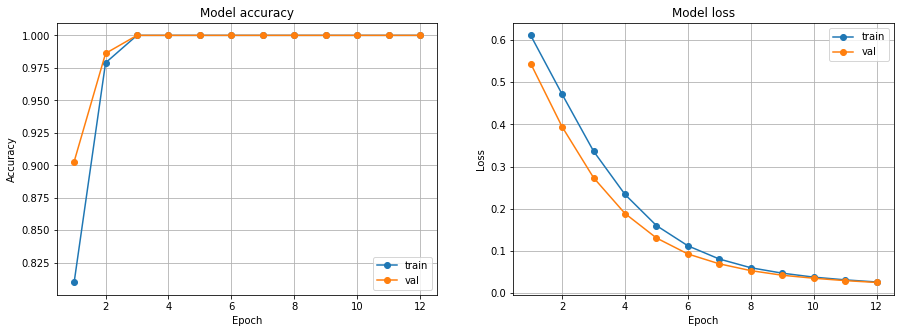

In [25]:
from time import time
t0 = time()

# reload the initial state of the NN to get repetable results:
key = 'dense_init'
model.load_weights(os.path.join('weights', key))

# set the seed for repetable tenssorflow random sequences:
tf.random.set_seed(SEED)

# train the network
hist = model.fit(data_train, y_train,
                 validation_data=(data_val, y_val), 
                 epochs=12, 
                 batch_size=32)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Epoch 1/12
18/18 [==============================] - 0s 6ms/step - loss: 0.5566 - accuracy: 0.8486 - val_loss: 0.4008 - val_accuracy: 1.0000
Epoch 2/12
18/18 [==============================] - 0s 2ms/step - loss: 0.2957 - accuracy: 1.0000 - val_loss: 0.1982 - val_accuracy: 1.0000
Epoch 3/12
18/18 [==============================] - 0s 3ms/step - loss: 0.1414 - accuracy: 1.0000 - val_loss: 0.0987 - val_accuracy: 1.0000
Epoch 4/12
18/18 [==============================] - 0s 3ms/step - loss: 0.0755 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 1.0000
Epoch 5/12
18/18 [==============================] - 0s 2ms/step - loss: 0.0481 - accuracy: 1.0000 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 6/12
18/18 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 7/12
18/18 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 8/12
18/18 [==

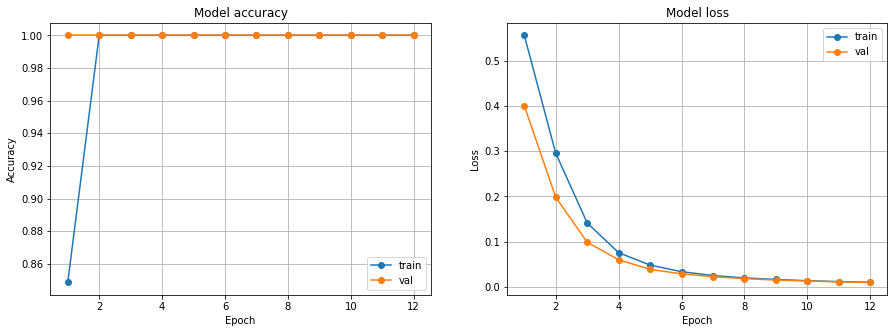

In [26]:
from time import time
t0 = time()

# reload the initial state of the NN to get repetable results:
key = 'dense_init'
model.load_weights(os.path.join('weights', key))

# set the seed for repetable tenssorflow random sequences:
tf.random.set_seed(SEED)

# train the network
hist = model.fit(data_train, y_train,
                 validation_data=(data_val, y_val), 
                 epochs=12, 
                 batch_size=16)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

$\leadsto$ **On voit que plus l'entraînement semble meilleur (`val_loss` plus faible) avec des valeurs de `batch_size` petite, par xemple 8 ou 16.**

### Sauvegarder les poids du réseau entraîné :

- Enregistrer les poids du réseau pour le meilleur entraînement dans le dossier `models` avec le préfixe `trained`.
- Faire afficher la liste des fichiers du dossier `weights` qui commencent par `trained`.

In [27]:
dir_name = "models"      # name of the directory where to save files 
if not os.path.exists(dir_name): os.mkdir(dir_name)

key = 'trained'
model.save_weights(os.path.join(dir_name, key))

# print file list:
files=[f for f in os.listdir(dir_name) if f.startswith(key)]
files.sort()
print(f"weight files in directory '{dir_name}':")
for f in files: print('\t',f)

weight files in directory 'models':
	 trained.data-00000-of-00001
	 trained.index


# 3 $-$ Évaluer les performances du réseau entraîné

Calculer les inférences (scalaires) du réseau entraîné en lui donnant en entrée les données de validation :

In [28]:
results = model.predict(data_val)
inferences = results.argmax(axis=-1)

print(f"inferences : {inferences}")

inferences : [1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0
 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1]


Calculer la précison (pourcentage de bonnes réponses) du réseau entraîné :

In [29]:
reponse_ok = (inferences == label_val)
print(f"nombre de réponses justes : {reponse_ok.sum()} sur {nb_val_set} jeux de données")

precision = reponse_ok.sum()/nb_val_set*100
print(f"précision du réseau entraîné : {precision} % de réponses justes")

nombre de réponses justes : 72 sur 72 jeux de données
précision du réseau entraîné : 100.0 % de réponses justes


Faire afficher la matrice de confusion, avec les labels écrits explicitement :

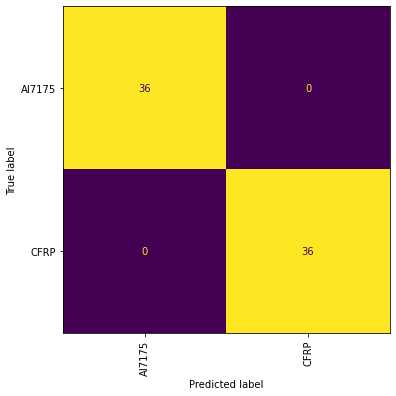

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(6,6))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(label_val, inferences, 
                                        ax=axis,
                                        display_labels=['Al7175','CFRP'], 
                                        xticks_rotation='vertical',
                                        colorbar=False);

# 4 - Entraîner le réseau de neurones avec seulement 1 indicateur à la fois parmi les 50

À cette étape du problème, l'idée est d'entraîner le RND non plus avec la globalité des 50 indicateurs, mais de considérer les indicateurs un par un, pour voir quelle est la précision du réseau entraîné avec les données de chaque indicateur pris séparément...

## 4.1 $-$ Construire le réseau de neurones pour 1 indicateur en entrée :

Définir le RND `model_1` identique au RND `model` sauf pour la couche d'entrée qui sera maintenant dimensionnée à `1`, compiler le réseau et afficher sa structure :

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nb_train_set = data_train.shape[0]    # number of training sets
nb_val_set   = data_val.shape[0]      # number of validation sets 
nb_classe    = 2                      # number of classes (material1, material2)

tf.random.set_seed(SEED)

# les 5 lignes pour construire le réseau de neurones:
model_1 = Sequential()
model_1.add(Input(shape=(1,), name='Input'))
model_1.add(Dense(100, activation='relu', name='C1'))
model_1.add(Dense(nb_classe, activation='softmax', name='Out'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

model_1.summary()    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Dense)                  (None, 100)               200       
                                                                 
 Out (Dense)                 (None, 2)                 202       
                                                                 
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


Affichage graphique de la structure du réseau :

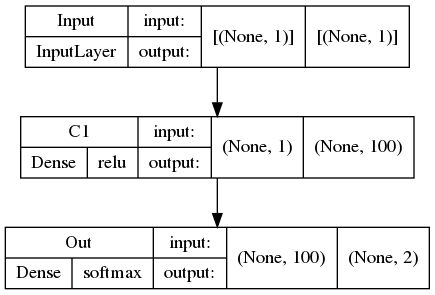

In [32]:
tf.keras.utils.plot_model(model_1, show_shapes=True, show_layer_activations=True)

### Sauvegarder les poids initiaux du réseau de neurones

- Enregistrer les poids du réseau de neurones initial dans le dossier `weights` avec le préfixe `dense_1_init`.
- Afficher la liste des fichiers du dossier `weights` qui commencent par `dense_1_init`.

In [33]:
# check that the directory exists and create it if required:
if not os.path.isdir("weights"): os.mkdir("weights")

# save the network weights:
key = 'dense_1_init'
model_1.save_weights(os.path.join('weights', key))

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/dense_1_init.index
weights/dense_1_init.data-00000-of-00001


## 4.2 $-$ Entraîner le réseau avec chacun des 50 indicateurs pris séparément

Construire une boucle réalisant 50 itérations, et à chaque itération `i` :
- Extraire les données d'entraînement et de validation correspondant à l'indicateur de rang `i`,
- Charger les poids initiaux du RND `model_1`,
- Fixer la graine des générateurs aléatoires de **tensorflow**,
- Entraîner le réseau avec les données d'entraînement et de validation de l'indicateur `i`, avec mesure des performance à chaque époque, en choisissant<br>
  les meilleures valeurs de `epoch` et `batch_size` compte tenu des résultats précédents.
- Calculer les inférences scalaires du réseau pour les données de validation, en déduire la précision du réseau entraîné avec l'indicateur de rang `i`,
- Stocker dans la liste `accuracy` la précision du réseau entraîné.
- Afficher la précision du réseau entraîné avec chacun des 50 indicateurs : à l'aide de la page [sphx-glr-plot-types-basic-bar-py](https://matplotlib.org/stable/plot_types/basic/bar.html#sphx-glr-plot-types-basic-bar-py) tracer un "diagramme en bâtons" avec la fonction `bar` du module **matplotlib**, montrant :
    - en abcisses, le rang des indicateurs de 0 à 49,
    - en ordonnées, la précision en % du réseau entrainé avec chacun des 50 indicateurs...<br>
      *indications* : on pourra passer l'argument `figsize=(15,5)` à l'appel de la fonction `plt.subplots` pour régler la taille de la figure...

 49

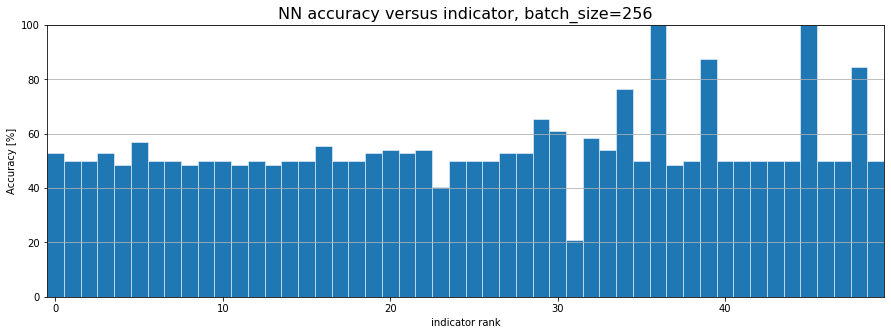


50 entraînement en 23 secondes
 49

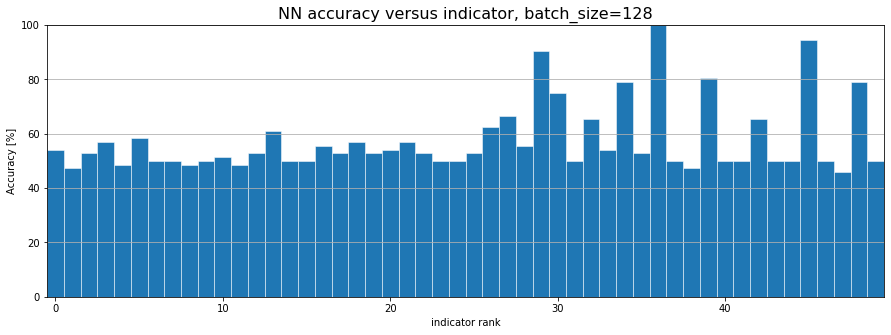


50 entraînement en 23 secondes
 49

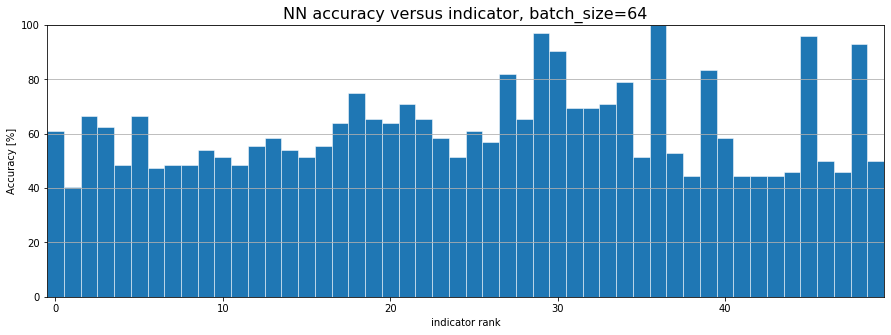


50 entraînement en 26 secondes
 49

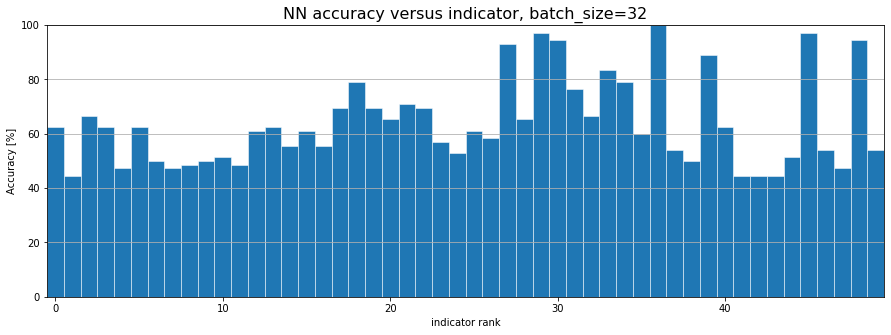


50 entraînement en 28 secondes
 49

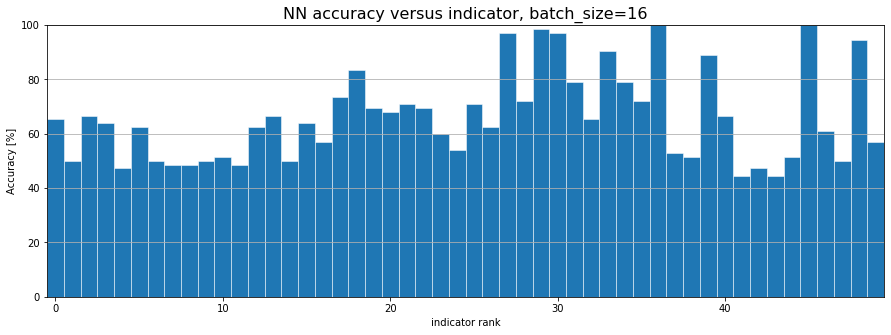


50 entraînement en 33 secondes
 49

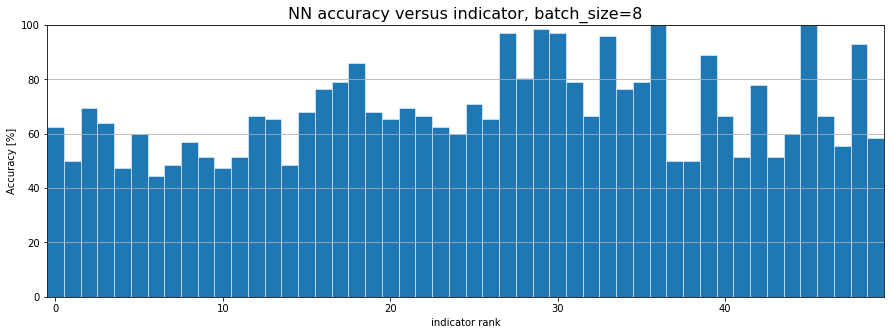


50 entraînement en 42 secondes


In [34]:
from time import time

accuracy = {}

for batch_size in 256, 128, 64, 32, 16, 8:
    
    t0 = time()
    accuracy[batch_size] = []
    
    for i in range(50):

        # take the indicator and the label of rank <i>:
        data_train_1 = data_train[:,i]
        data_val_1   = data_val[:,i]

        # reload the initial NN state:
        key = 'dense_1_init'
        model_1.load_weights(os.path.join('weights', key))

        tf.random.set_seed(SEED)

        # train the NN:
        print(f"\r",i, end="")
        hist = model_1.fit(data_train_1, y_train,
                           validation_data=(data_val_1, y_val), 
                           epochs=12, 
                           batch_size=batch_size,
                           verbose=0)

        # evaluate the NN:
        inf_1 = model_1.predict(data_val_1).argmax(axis=-1)
        ok = (inf_1 == label_val)
        ac = ok.sum()/nb_val_set*100
        accuracy[batch_size].append(ac)
        
    x = list(range(50))
    indic_labels = list(range(50))
    fig, ax = plt.subplots(figsize=(15,5))

    width=1
    ax.bar(x, accuracy[batch_size], width=width, edgecolor="white", linewidth=0.5)
    ax.set_ylabel('Accuracy [%]')
    ax.set_xlabel('indicator rank')
    ax.set_title(f'NN accuracy versus indicator, batch_size={batch_size}', fontsize=16)
    #ax.set_xticks(x, indic_labels)
    ax.set_xlim(0-width/2, 50-width/2)
    ax.set_ylim(0,100)
    ax.grid(axis='y')
    plt.show()

    print(f"\n50 entraînement en {(time()-t0):.0f} secondes")    

## 4.3 $-$ Rechercher les indicateurs les plus pertinents

L'allure de la figure précédente suggère que certains indicateurs n'offrent aucune pertinence pour la classification du matériau percé (précision égale à 50 % $\leadsto$ la même que si on classait les matériaux au hasard...), alors que d'autres conduisent à eux seuls à des précisions de classification supérieures à 80 voire 90 %.

Faire afficher les labels des indicateurs donnant un réseau entraîné dont la précision est meilleure que 90% :

In [35]:
labels = np.array(header[15:-3])
accuracy = np.array(accuracy[8])
ranks = np.where(accuracy >= 90)[0]
best_indic = []
for acc, label, rank in zip(accuracy[ranks], labels[ranks], ranks):
    print(f"{acc:.0f}% avec l'indicateur '{label}', rang {rank}")
    best_indic.append((acc, rank, label))

97% avec l'indicateur 'KcITorque', rang 27
99% avec l'indicateur 'min Itorque', rang 29
97% avec l'indicateur 'moyenneITorque', rang 30
96% avec l'indicateur 'skewITorque', rang 33
100% avec l'indicateur 'AmpFz_passage dents', rang 36
100% avec l'indicateur 'AmpVzpiece_passage dents', rang 45
93% avec l'indicateur 'AmpVypiece_passage dents', rang 48


Classer par ordre décroissant de précision les indicateurs sélectionnés (afficher la précision, le label et le rang des indicateurs):

In [36]:
best_indic.sort(reverse=True)

In [37]:
for a, r, l in best_indic:
    print(f"{a:.0f}% avec l'indicateur '{l}', rang {r}")

100% avec l'indicateur 'AmpVzpiece_passage dents', rang 45
100% avec l'indicateur 'AmpFz_passage dents', rang 36
99% avec l'indicateur 'min Itorque', rang 29
97% avec l'indicateur 'moyenneITorque', rang 30
97% avec l'indicateur 'KcITorque', rang 27
96% avec l'indicateur 'skewITorque', rang 33
93% avec l'indicateur 'AmpVypiece_passage dents', rang 48


# 5 $-$ Entraînement final avec les indicateurs les plus pertinents

Parmis les capteurs utilisables sur le banc de perçage, certains sont compliqués à rajouter (par exemple le capteur de force axiale), d'autres sont relativement simples à ajouter (les accéléromètres par exemple) et d'autres encore sont installés de façon native quand le banc est construit (comme les capteurs de courant...) et sont donc particulièrement intéressants à utiliser..

Refaire l'entraînement du RND en ne conservant que le[s] indicateur[s] que vous jugez pertinent[s], donnant une précision meilleure que 90 %.<br>
Expliquez pourquoi les indicateurs que vous avez retenus sont des indicateurs *pertinents*<br>
Faire afficher la matrice de confusion...

On peut retenir par exemple l'indicateur de rang *29* qui correspond à un capteur électrique installé de façon native sur le banc d'essai.

In [38]:
good_ranks = [29]

In [39]:
indic_label = np.array(header[15:-3])
good_labels = labels[good_ranks]
good_ranks, good_labels

([29], array(['min Itorque'], dtype='<U24'))

In [40]:
# take the indicator and the label of rank <i>:
data_train_best = data_train[:,good_ranks]
data_val_best   = data_val[:,good_ranks]

In [41]:
data_train_best.shape, data_val_best.shape

((284, 1), (72, 1))

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nb_train_set = data_train_best.shape[0]    # number of training sets
nb_val_set   = data_val_best.shape[0]      # number of validation sets 
set_size     = data_train_best.shape[1]    # number of scalars in a set 
nb_classe    = 2                           # number of classes (material1, material2)

tf.random.set_seed(SEED)

# les 5 lignes pour construire le réseau de neurones:
model_2 = Sequential()
model_2.add(Input(shape=(set_size,), name='Input'))
model_2.add(Dense(100, activation='relu', name='C1'))
model_2.add(Dense(nb_classe, activation='softmax', name='Out'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

model_2.summary()    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Dense)                  (None, 100)               200       
                                                                 
 Out (Dense)                 (None, 2)                 202       
                                                                 
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


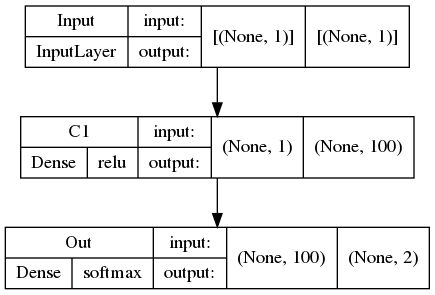

In [43]:
tf.keras.utils.plot_model(model_2, show_shapes=True, show_layer_activations=True)

Durée entraînement : 0.90 secondes


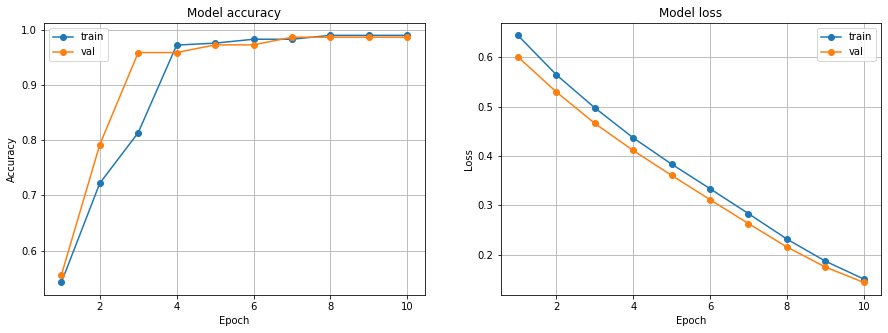

In [44]:
tf.random.set_seed(SEED)
t0 = time()
hist = model_2.fit(data_train_best, y_train,
                   validation_data=(data_val_best, y_val), 
                   epochs=10, 
                   batch_size=8,
                   verbose=0)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

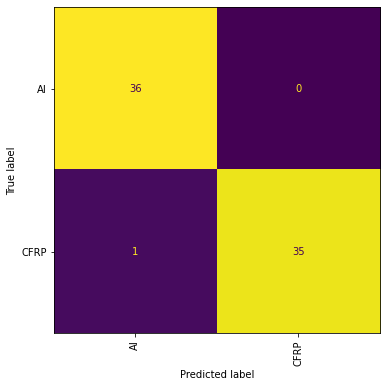

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

inf_best = model_2.predict(data_val_best).argmax(axis=-1)

fig = plt.figure(figsize=(6,6))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(label_val, inf_best, 
                                        ax=axis,
                                        display_labels=['Al','CFRP'], 
                                        xticks_rotation='vertical',
                                        colorbar=False);

En ajoutant l'indicateur `AmpVzpiece_passage dents` (basé sur des données d'accéléromètre, rang 45) on peut avoir 100 % de réponses justes :

In [54]:
good_ranks = [29, 45]

In [55]:
indic_label = np.array(header[15:-3])
good_labels = labels[good_ranks]
good_ranks, good_labels

([29, 45], array(['min Itorque', 'AmpVzpiece_passage dents'], dtype='<U24'))

In [56]:
# take the indicator and the label of rank <i>:
data_train_best = data_train[:,good_ranks]
data_val_best   = data_val[:,good_ranks]

In [57]:
data_train_best.shape, data_val_best.shape

((284, 2), (72, 2))

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nb_train_set = data_train_best.shape[0]    # number of training sets
nb_val_set   = data_val_best.shape[0]      # number of validation sets 
set_size     = data_train_best.shape[1]    # number of scalars in a set 
nb_classe    = 2                           # number of classes (material1, material2)

tf.random.set_seed(SEED)

# les 5 lignes pour construire le réseau de neurones:
model_3 = Sequential()
model_3.add(Input(shape=(set_size,), name='Input'))
model_3.add(Dense(100, activation='relu', name='C1'))
model_3.add(Dense(nb_classe, activation='softmax', name='Out'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

model_3.summary()    

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Dense)                  (None, 100)               300       
                                                                 
 Out (Dense)                 (None, 2)                 202       
                                                                 
Total params: 502
Trainable params: 502
Non-trainable params: 0
_________________________________________________________________


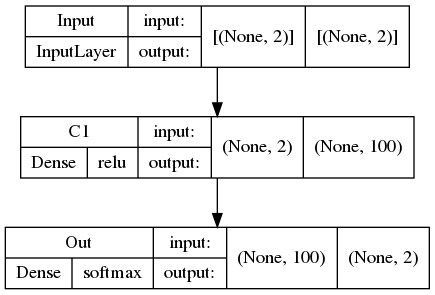

In [59]:
tf.keras.utils.plot_model(model_3, show_shapes=True, show_layer_activations=True)

Durée entraînement : 0.93 secondes


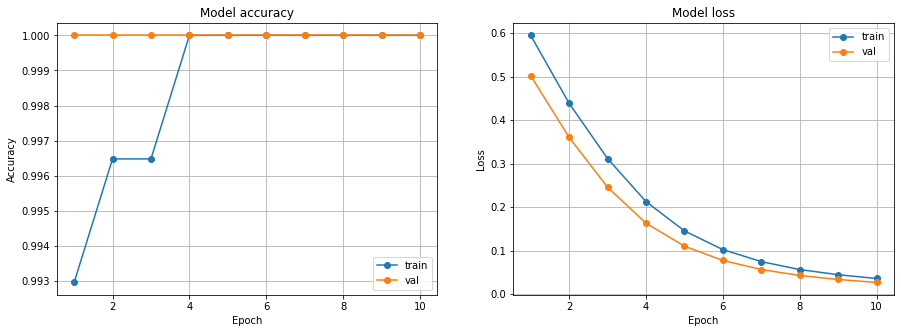

In [60]:
tf.random.set_seed(SEED)
t0 = time()
hist = model_3.fit(data_train_best, y_train,
                   validation_data=(data_val_best, y_val), 
                   epochs=10, 
                   batch_size=8,
                   verbose=0)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

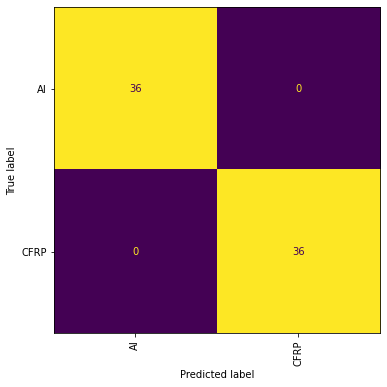

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

inf_best = model_3.predict(data_val_best).argmax(axis=-1)

fig = plt.figure(figsize=(6,6))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(label_val, inf_best, 
                                        ax=axis,
                                        display_labels=['Al','CFRP'], 
                                        xticks_rotation='vertical',
                                        colorbar=False);

# 6 $-$ Bilan

- Quelles conclusions tirez-vous de la résolution de ce problème ?

On peut entraîner un simple réseau de neurones dense à reconnaître le matériau percé avec seulement l'indicateur `min Itorque`. 

L'entraînement avec cet indicateurs dure moins de 1 seconde, et la prédiction est quasi-instantannée.

- Quelles applications pourriez-vous envisager pour ce réseau entraîné à classifier le matériau percé ?

Ceci permettrait de concevoir un *smart drilling bench" où les paramètres de perçage pourraient être ajustés en temps réel en fonction du matériau percé.

- Quelles suite pourriez-vous donner à cette étude ?

Entraîner le réseau de neurones à classifier l'usure du forêt par exemple.
